## Introduction

Our project is to forecast those customers who will become loyal to the product based on the processed data of offering incentives (a.k.a. coupons) to a large number of customers. The customers who are offered a discount and redeem the offer are the focus of this project. We are going to build models to predict which of the target customers will return to purchase the same item again.

The dataset we have includes a minimum of a year of shopping history prior to each customer's incentive, as well as the purchase histories of many other shoppers. The transaction history contains all items purchased, not just items related to the offer. Only one offer per customer is included in the data. The training set is comprised of offers issued before 2013-05-01. The test set is offers issued on or after 2013-05-01.

The workflow of this project includes data preprocessing, data manipulation, feature engineering, exploratory data analysis and model building. We create various predictive models including logistic regression, decision tree, random forests and xgboost. We also obtain the feature importance and performance measurement after obtaining the model results.

## Initial set-up & data preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import datasets
from sklearn.feature_selection import RFE
#import seaborn as sns
#sns.set(style="white")
#sns.set(style="whitegrid", color_codes=True)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reduce the size of the data
Here we select chain 2, 4 and 8. Save the file as reduced2.csv

In [ ]:
#Chosing transactions from 3 chains of the store.
loc_transactions = "data/transactions.csv"
loc_reduced = "data/reduced2.csv"  #Output file 
def reduce_data(loc_transactions, loc_reduced):
    with open(loc_reduced, "w") as outfile:
        for e, line in enumerate( open(loc_transactions) ):
            if line.split(",")[1] in ['2','4','8']:  # Add more chains by adding the chain_id to list. Eg. to add chain_id 16 use ['2','4','8','16'] instead of ['2','4','8']
                outfile.write( line )

reduce_data(loc_transactions, loc_reduced)
# reduced2.csv contains transactions from the chain ids mentioned in list above (['2','4','8'])
# redcued2.csv is your subset of the transactions data. Look at the customers present in this transactions 

## Data Loading

#### 1. reduced transaction data - here we selected only 3 chains with id 2, 4 and 8.

In [35]:
data=pd.read_csv("data/reduced2.csv",header=None,names=["id","chain","dept",'category','company','brand','date','productsize','productmeasure','productquantity','productamount'])
data.head()


,id,chain,dept,category,company,brand,date,productsize,productmeasure,productquantity,productamount
0,12524696,4,58,5833,103760030,8501,2012-03-02,24.00,OZ,2,10.00
1,12524696,4,58,5833,103760030,8501,2012-03-02,18.40,OZ,1,3.23
2,12524696,4,99,9901,107989373,12908,2012-03-02,0.66,OZ,1,2.19
3,12524696,4,57,5710,103663232,4568,2012-03-06,5.30,OZ,2,2.00
4,12524696,4,9,907,102113020,15704,2012-03-06,16.00,OZ,1,1.69


#### 2. Training data  - containing incentives offered to each customer and their response afterwards

In [36]:
#Read the training data
#train=pd.read_csv("trainHistory.csv",header=1,names=["id","chain","offer",'market','repeattrips','repeater','offerdate'])
train = pd.read_csv("data/trainHistory.csv")
print(len(train))
train.head()

160057


,id,chain,offer,market,repeattrips,repeater,offerdate
0,86246,205,1208251,34,5,t,2013-04-24
1,86252,205,1197502,34,16,t,2013-03-27
2,12682470,18,1197502,11,0,f,2013-03-28
3,12996040,15,1197502,9,0,f,2013-03-25
4,13089312,15,1204821,9,0,f,2013-04-01


In [5]:
len(train['id'].unique())

160057

#### 3. Offer data

In [38]:
#Read the offers data
offer=pd.read_csv("data/offers.csv",header=1,names=['offer','category','quantity','company','offervalue','brand'])
offer.head()

,offer,category,quantity,company,offervalue,brand
0,1194044,9909,1,107127979,1.00,6732
1,1197502,3203,1,106414464,0.75,13474
2,1198271,5558,1,107120272,1.50,5072
3,1198272,5558,1,107120272,1.50,5072
4,1198273,5558,1,107120272,1.50,5072


### Data preprocessing

In [39]:
#Count how many people will return to store in training data
train['repeater'].value_counts()

f    116619
t     43438
Name: repeater, dtype: int64

In [40]:
(train['repeater'][1]=='f')

False

In [41]:
#Convert the value in repeater column into integer
train.repeater = (train.repeater == 't').astype(int)
train.head()

,id,chain,offer,market,repeattrips,repeater,offerdate
0,86246,205,1208251,34,5,1,2013-04-24
1,86252,205,1197502,34,16,1,2013-03-27
2,12682470,18,1197502,11,0,0,2013-03-28
3,12996040,15,1197502,9,0,0,2013-03-25
4,13089312,15,1204821,9,0,0,2013-04-01


In [11]:
print(train.shape)
print(data.shape)
print(len(set(train.id)&set(data.id)))

(160057, 7)
(9480946, 11)
4732


#### Merge Offer data with Training data on "offer" and save the merged data as train_offer.

In [42]:
train_offer = pd.merge(train,offer,how='left',on='offer')
print(len(train_offer[train_offer['company'].notnull()]))
train_offer = train_offer.rename(columns={'company': 'offer_company','brand':'offer_brand','category':'offer_category'})
train_offer.head()

160057


,id,chain,offer,market,repeattrips,repeater,offerdate,offer_category,quantity,offer_company,offervalue,offer_brand
0,86246,205,1208251,34,5,1,2013-04-24,2202,1,104460040,2.00,3718
1,86252,205,1197502,34,16,1,2013-03-27,3203,1,106414464,0.75,13474
2,12682470,18,1197502,11,0,0,2013-03-28,3203,1,106414464,0.75,13474
3,12996040,15,1197502,9,0,0,2013-03-25,3203,1,106414464,0.75,13474
4,13089312,15,1204821,9,0,0,2013-04-01,5619,1,107717272,1.50,102504


In [10]:
print(train_offer.shape)
print(train.shape)
print(len(train.id.unique()))
print(len(data.id.unique()))

(160057, 12)
(160057, 7)
160057
8946


In [13]:
print('transaction:',data.columns)
print('train: ',train.columns)
print('offer: ',offer.columns)
print('offer: ',train_offer.columns)

transaction: Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount'],
      dtype='object')
train:  Index(['id', 'chain', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate'],
      dtype='object')
offer:  Index(['offer', 'category', 'quantity', 'company', 'offervalue', 'brand'], dtype='object')
offer:  Index(['id', 'chain', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand'],
      dtype='object')


In [121]:
def univariate_plotter(feature='No feature passed', train_sub_col_target=0, target_col='1', bins=10):
    X_train = train_sub_col_target.copy()
    X_train['y'] = train_sub_col_target[target_col]
    #for col_number in range(7, 8):
    col = feature #X_train.columns[col_number]
    print('Below are the actual found rates wrt ' + col)
    nan_flag=0
    if pd.isnull(X_train[col]).sum()>0:
        nan_flag=1
        print("NANs present")
    bins = bins
    # cuts=[0]
    cuts=[]
    prev_cut = -1000000000
    if nan_flag!=1:
        for i in range(bins+1):
            next_cut = np.percentile(train_sub_col_target[col], i*100/bins)
            if next_cut!=prev_cut:
                cuts.append(next_cut)
            prev_cut = next_cut#.copy()
        #print(cuts)
        cuts[0] = cuts[0]-1
        cuts[len(cuts)-1] = cuts[len(cuts)-1]+1
        #cuts=[ -1, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 2]
        cut_series = pd.cut(X_train[col], cuts)
    else:
        train_sub_col_no_nan = train_sub_col_target[col].copy()
        train_sub_col_no_nan[np.isinf(train_sub_col_no_nan)]=np.nan
        train_sub_col_no_nan = train_sub_col_no_nan[~np.isnan(train_sub_col_no_nan)]
        X_train[col][np.isinf(X_train[col])]=np.nan
        X_train_no_nan = X_train[~np.isnan(X_train[col])]

        for i in range(bins+1):
            next_cut = np.percentile(train_sub_col_no_nan, i*100/bins)
            if next_cut!=prev_cut:
                cuts.append(next_cut)
            prev_cut = next_cut.copy()

        cuts[0] = cuts[0]-0.00001
        cuts[len(cuts)-1] = cuts[len(cuts)-1]+0.00001
        #cuts=[ -1, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05]
        cut_series = pd.cut(X_train_no_nan[col], cuts)
        cut_series_test = pd.cut(X_test_no_nan[col], cuts)
        #print(cuts)
    if nan_flag!=1:
        
        grouped = X_train.groupby([cut_series], as_index=True).agg({'y':[np.size, np.mean], col:[np.mean]})
        grouped1 = pd.DataFrame(grouped.index)
        grouped = X_train.groupby([cut_series], as_index=False).agg({'y':[np.size, np.mean], col:[np.mean]})
        grouped.columns = ['_'.join(cols).strip() for cols in grouped.columns.values]
        
        grouped = pd.DataFrame(grouped.to_records())
        grouped1['y_mean'] = grouped['y_mean']
        grouped1['y_sum'] = grouped['y_size']
        grouped1[col+'_mean'] = grouped[col+'_mean']

    else:
        grouped = X_train_no_nan.groupby([cut_series], as_index=True).agg({'y':[np.size, np.mean]})
        grouped1 = pd.DataFrame(grouped.index)
        grouped = X_train_no_nan.groupby([cut_series], as_index=False).agg({'y':[np.size, np.mean]})
        grouped.columns = ['_'.join(cols).strip() for cols in grouped.columns.values]
        grouped = pd.DataFrame(grouped.to_records())
        grouped1['y_mean'] = grouped['y_mean']
        grouped1['y_sum'] = grouped['y_sum']
        grouped1_nan = grouped1[0:1]
        grouped1_nan[col] = (grouped1_nan[col]).astype('str')
        grouped1_nan[col][0] = 'Nan'
        grouped1_nan['y_mean'][0] = y_train[np.isnan(X_train[col])].mean()
        grouped1_nan['y_sum'][0] = y_train[np.isnan(X_train[col])].sum()    
        grouped1 = pd.concat([grouped1, grouped1_nan])

    grouped1=grouped1.reset_index(drop=True)
    a = plt.plot(grouped1['y_mean'], marker = 'o')
    plt.xticks(np.arange(len(grouped1)), (grouped1[col]).astype('str'), rotation=45)
    plt.xlabel('Bins of '+feature)
    plt.ylabel('Bin-wise percentage repeater')
    plt.show()
    b = plt.bar(np.arange(len(grouped1)), grouped1['y_sum'], alpha=0.5)
    plt.xticks(np.arange(len(grouped1)), (grouped1[col]).astype('str'), rotation=45)
    plt.xlabel('Bins of '+feature)
    plt.ylabel('Bin-wise Population')
    plt.show()
    return(grouped1)

#### Merge train_offer with Reduced transaction data on customer ID

In [43]:
reduced_transaction_offer = pd.merge(data,train_offer[['id','offer_company','offer_brand','offer_category','offerdate']],how = 'left',on='id')


In [30]:
reduced_transaction_offer.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,productquantity,productamount,offer_company,offer_brand,offer_category,offerdate
0,12524696,4,58,5833,103760030,8501,2012-03-02,24.00,OZ,2,10.00,NaN,NaN,NaN,NaN
1,12524696,4,58,5833,103760030,8501,2012-03-02,18.40,OZ,1,3.23,NaN,NaN,NaN,NaN
2,12524696,4,99,9901,107989373,12908,2012-03-02,0.66,OZ,1,2.19,NaN,NaN,NaN,NaN
3,12524696,4,57,5710,103663232,4568,2012-03-06,5.30,OZ,2,2.00,NaN,NaN,NaN,NaN
4,12524696,4,9,907,102113020,15704,2012-03-06,16.00,OZ,1,1.69,NaN,NaN,NaN,NaN


In [44]:
b = reduced_transaction_offer.groupby(['id'],as_index = False).agg({'offerdate':np.max})
b.head()

,id,offerdate
0,12524696,NaN
1,13501141,NaN
2,13744500,NaN
3,13807224,2013-04-05
4,13873775,2013-03-26


### Feature Engineering
#### Find the most recent purchase date of each customer

In [45]:
has_bought_ = reduced_transaction_offer.groupby(['id'],as_index = False).agg({'date':np.max})

In [27]:
has_bought_.head()

,id,date
0,12524696,2013-06-19
1,13501141,2013-05-08
2,13744500,2013-06-15
3,13807224,2013-04-03
4,13873775,2013-03-23


In [88]:
print(has_bought_.shape)
print(has_bought_[has_bought_['date'].notnull()].shape)

(8946, 2)
(8946, 2)


#### Additional feature: Most recent purchasing date

In [46]:
train_offer_ = pd.merge(train_offer,has_bought_[['id','date']],
                                     how = 'left',on = 'id')
print(train_offer_[train_offer_['date'].notnull()].shape)
train_offer_ =(train_offer_[train_offer_['date'].notnull()])
train_offer_.head()

(4732, 13)


,id,chain,offer,market,repeattrips,repeater,offerdate,offer_category,quantity,offer_company,offervalue,offer_brand,date
8,13807224,4,1204576,1,0,0,2013-04-05,5616,1,104610040,1.00,15889,2013-04-03
9,13873775,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-23
10,13974451,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-13
12,14381137,4,1197502,1,0,0,2013-04-04,3203,1,106414464,0.75,13474,2013-03-23
19,15994113,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-24


#### Additional feature: Delta. delta is the number of 30 days, i.e. if delta = 1, then it means 30 days, if delta = 60, it means 60 days and etc. 

In [47]:
from datetime import datetime
import math
def __datetime(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')
#delta is the number of 30 days, i.e. if delta = 1, then it means 30 days, if delta = 60, it means 60 days and etc. 
delta = (train_offer_.offerdate.apply(__datetime)-train_offer_.date.apply(__datetime))
train_offer_.columns

Index(['id', 'chain', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date'],
      dtype='object')

In [48]:
delta.shape
delta1 = delta
#delta1 = pd.to_timedelta(delta,unit='d').astype('timedelta64[D]')
delta1 = delta1/30
delta1 = delta1.dt.ceil('D')
delta1 = delta1.dt.days
#delta1.head()

In [92]:
print(reduced_transaction_offer.shape)
print(reduced_transaction_offer.columns)

(9480946, 15)
Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount',
       'offer_company', 'offer_brand', 'offer_category', 'offerdate'],
      dtype='object')


In [49]:
##### Find transactional data with company of the transaction equal to company of the offer
reduced_transaction_offer_ = reduced_transaction_offer[reduced_transaction_offer['company'] == 
                                                      reduced_transaction_offer['offer_company']]
reduced_transaction_offer_.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,productquantity,productamount,offer_company,offer_brand,offer_category,offerdate
5746,13807224,4,56,5610,104610040,15889,2012-06-25,5.00,OZ,1,4.49,104610040.0,15889.0,5616.0,2013-04-05
5845,13807224,4,56,5616,104610040,15889,2012-08-01,6.67,OZ,1,3.00,104610040.0,15889.0,5616.0,2013-04-05
5846,13807224,4,56,5616,104610040,15889,2012-08-01,7.50,OZ,1,3.00,104610040.0,15889.0,5616.0,2013-04-05
5996,13807224,4,56,5616,104610040,15889,2012-09-17,7.60,OZ,1,2.99,104610040.0,15889.0,5616.0,2013-04-05
5997,13807224,4,56,5616,104610040,15889,2012-09-17,6.67,OZ,1,2.99,104610040.0,15889.0,5616.0,2013-04-05


In [94]:
print(len(reduced_transaction_offer_.id.unique()))
#print(len(reduced_transaction_offer_brand.id.unique()))

2438


In [95]:
print(reduced_transaction_offer_.shape)
print(reduced_transaction_offer_.columns)

(12637, 15)
Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount',
       'offer_company', 'offer_brand', 'offer_category', 'offerdate'],
      dtype='object')


##### Calculate total amount and number of times each customer has bought from each company on offer

In [50]:
#Total amount and number of times each customer spent in each company
has_bought_ = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.size)
has_bought_amount = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.sum)
#print(has_bought_company.head())
print(has_bought_.columns)
#has_bought_company_amount.head()
has_bought_.head()

Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount',
       'offer_company', 'offer_brand', 'offer_category', 'offerdate'],
      dtype='object')


,id,chain,dept,category,company,brand,date,productsize,productmeasure,productquantity,productamount,offer_company,offer_brand,offer_category,offerdate
0,13807224,7,7,7,7,7,7,7.0,7,7,7.0,7.0,7.0,7.0,7
1,13873775,16,16,16,16,16,16,16.0,16,16,16.0,16.0,16.0,16.0,16
2,16138642,2,2,2,2,2,2,2.0,2,2,2.0,2.0,2.0,2.0,2
3,16535563,3,3,3,3,3,3,3.0,3,3,3.0,3.0,3.0,3.0,3
4,18277411,15,15,15,15,15,15,15.0,15,15,15.0,15.0,15.0,15.0,15


#### Additional features: 1. has_bought_company;  2. has_bought_company_amount, 3. has_bought_company_quantity

In [51]:
train_offer_ = pd.merge(train_offer_,has_bought_[['id','chain']],
                                     how = 'left',on = 'id')
train_offer_ = pd.merge(train_offer_,has_bought_amount[['id','productamount','productquantity']],
                                     how = 'left',on = 'id')

train_offer_.head()

,id,chain_x,offer,market,repeattrips,repeater,offerdate,offer_category,quantity,offer_company,offervalue,offer_brand,date,chain_y,productamount,productquantity
0,13807224,4,1204576,1,0,0,2013-04-05,5616,1,104610040,1.00,15889,2013-04-03,7.0,23.95,7.0
1,13873775,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-23,16.0,61.35,56.0
2,13974451,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-13,NaN,NaN,NaN
3,14381137,4,1197502,1,0,0,2013-04-04,3203,1,106414464,0.75,13474,2013-03-23,NaN,NaN,NaN
4,15994113,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-24,NaN,NaN,NaN


In [98]:
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'chain_y', 'productamount',
       'productquantity'],
      dtype='object')

In [52]:
print(train_offer_.shape)
#print(len([reduced_transaction_offer['chain_y'].notnull()]))
#print(reduced_transaction_offer[reduced_transaction_offer['chain_y'].notnull()].shape
train_offer_ = train_offer_.rename(
    columns={'chain_y': 'has_bought_company','productamount':'has_bought_company_amount','productquantity':'has_bought_company_q'})
train_offer_.head()

(4732, 16)


,id,chain_x,offer,market,repeattrips,repeater,offerdate,offer_category,quantity,offer_company,offervalue,offer_brand,date,has_bought_company,has_bought_company_amount,has_bought_company_q
0,13807224,4,1204576,1,0,0,2013-04-05,5616,1,104610040,1.00,15889,2013-04-03,7.0,23.95,7.0
1,13873775,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-23,16.0,61.35,56.0
2,13974451,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-13,NaN,NaN,NaN
3,14381137,4,1197502,1,0,0,2013-04-04,3203,1,106414464,0.75,13474,2013-03-23,NaN,NaN,NaN
4,15994113,4,1197502,1,0,0,2013-03-26,3203,1,106414464,0.75,13474,2013-03-24,NaN,NaN,NaN


#### Find transactional data with brand of the transaction equal to brand of the offer

In [53]:
reduced_transaction_offer_ = reduced_transaction_offer[reduced_transaction_offer['brand'] == 
                                                      reduced_transaction_offer['offer_brand']]
reduced_transaction_offer_.shape

(8858, 15)

#### Calculate total amount and number of times each customer has bought from each brand on an offer

In [54]:
has_bought_ = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.size)
has_bought_amount = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.sum)
#print(has_bought_brand.head())
print(has_bought_amount.shape)
print(has_bought_.columns)

(1564, 12)
Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount',
       'offer_company', 'offer_brand', 'offer_category', 'offerdate'],
      dtype='object')


#### Additional features: 1. has_bought_brand; 2. has_bought_brand_amount, 3. has_bought_brand_quantity

In [55]:
train_offer_ = pd.merge(train_offer_,has_bought_[['id','chain']],
                                     how = 'left',on = 'id')
train_offer_ = pd.merge(train_offer_,has_bought_amount[['id','productamount','productquantity']],
                                     how = 'left',on = 'id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'chain',
       'productamount', 'productquantity'],
      dtype='object')

In [56]:
print(train_offer_.shape)
train_offer_ = train_offer_.rename(
    columns={'chain': 'has_bought_brand','productamount':'has_bought_brand_amount',
             'productquantity':'has_bought_brand_q'})
train_offer_.head()

print(train_offer_[train_offer_['has_bought_brand'].notnull()].shape)

(4732, 19)
(1564, 19)


In [57]:
reduced_transaction_offer_ = reduced_transaction_offer[reduced_transaction_offer['category'] == 
                                                      reduced_transaction_offer['offer_category']]
reduced_transaction_offer_.shape

(16817, 15)

In [58]:
has_bought_ = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.size)
has_bought_amount = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.sum)
#print(has_bought_brand.head())
print(has_bought_.columns)

print(has_bought_amount.columns)

Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount',
       'offer_company', 'offer_brand', 'offer_category', 'offerdate'],
      dtype='object')
Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'productsize',
       'productquantity', 'productamount', 'offer_company', 'offer_brand',
       'offer_category'],
      dtype='object')


#### Additional features: 1. has_bought_category; 2. has_bought_category_amount, 3. has_bought_category_quantity

In [59]:
train_offer_ = pd.merge(train_offer_,has_bought_[['id','chain']],
                                     how = 'left',on = 'id')
train_offer_ = pd.merge(train_offer_,has_bought_amount[['id','productamount','productquantity']],
                                     how = 'left',on = 'id')


In [60]:
print(train_offer_.shape)
train_offer_ = train_offer_.rename(
    columns={'chain': 'has_bought_category','productamount':'has_bought_category_amount','productquantity':'has_bought_category_q'})
#reduced_transaction_offer.head()
print(train_offer_[train_offer_['has_bought_category'].notnull()].shape)

(4732, 22)
(1861, 22)


In [61]:
reduced_transaction_offer_ = reduced_transaction_offer[reduced_transaction_offer['category'] == 
                                                      reduced_transaction_offer['offer_category']]
reduced_transaction_offer_ = reduced_transaction_offer_[reduced_transaction_offer_['brand'] == 
                                                      reduced_transaction_offer_['offer_brand']]
reduced_transaction_offer_ = reduced_transaction_offer_[reduced_transaction_offer_['company'] == 
                                                      reduced_transaction_offer_['offer_company']]

In [62]:
has_bought_ = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.size)
has_bought_amount = reduced_transaction_offer_.groupby(['id'],as_index = False).agg(np.sum)
#print(has_bought_brand.head())
print(has_bought_.columns)

#print(has_bought_amount.columns)

Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount',
       'offer_company', 'offer_brand', 'offer_category', 'offerdate'],
      dtype='object')


In [63]:
train_offer_ = pd.merge(train_offer_,has_bought_[['id','chain']],
                                     how = 'left',on = 'id')

In [64]:
train_offer_ = pd.merge(train_offer_,has_bought_amount[['id','productamount','productquantity']],
                                     how = 'left',on = 'id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'chain',
       'productamount', 'productquantity'],
      dtype='object')

#### Additional feature: 1.  has_bought_all 2. has_bought_all_amount 3. has_bought_all_q

In [65]:
print(train_offer_.shape)
train_offer_ = train_offer_.rename(
    columns={'chain': 'has_bought_all','productamount':'has_bought_all_amount','productquantity':'has_bought_all_q'})
#reduced_transaction_offer.head()

print(train_offer_[train_offer_['has_bought_category'].notnull()].shape)

(4732, 25)
(1861, 25)


In [66]:
train_offer_ = train_offer_.assign(Delta = delta1)

In [42]:
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta'],
      dtype='object')

In [35]:
train_offer_.Delta.unique()

array([ nan,   1.,   2.,   3.])

In [114]:
print(train_offer_.columns)
print(offer.columns)

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta'],
      dtype='object')
Index(['offer', 'category', 'quantity', 'company', 'offervalue', 'brand'], dtype='object')


In [67]:
has_bought_ = reduced_transaction_offer.groupby(['id'],as_index = False).agg(np.size)
has_bought_amount = reduced_transaction_offer.groupby(['id'],as_index = False).agg(np.sum)

In [37]:
print(has_bought_.shape)
print(has_bought_.columns)
print(has_bought_amount.columns)
print(reduced_transaction_offer.shape)
print(len(reduced_transaction_offer.id.unique()))
#has_bought_.head()

(8946, 15)
Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'date',
       'productsize', 'productmeasure', 'productquantity', 'productamount',
       'offer_company', 'offer_brand', 'offer_category', 'offerdate'],
      dtype='object')
Index(['id', 'chain', 'dept', 'category', 'company', 'brand', 'productsize',
       'productquantity', 'productamount', 'offer_company', 'offer_brand',
       'offer_category'],
      dtype='object')
(9480946, 15)
8946


#### Additional feature: 1.  total_amount, 2. total_q

In [68]:
train_offer_ = pd.merge(train_offer_,has_bought_[['id','chain']],how='left',on='id')
train_offer_ = pd.merge(train_offer_,has_bought_amount[['id','productquantity','productamount']],how = 'left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'chain',
       'productquantity', 'productamount'],
      dtype='object')

In [69]:
train_offer_ = train_offer_.rename(
    columns={'chain': 'total_times','productamount':'total_amount','productquantity':'total_q'})
#reduced_transaction_offer.head()

In [41]:
print(train_offer_.shape)
train_offer_.head()

(4732, 29)


,id,chain_x,offer,market,repeattrips,repeater,offerdate,offer_category,quantity,offer_company,...,has_bought_category,has_bought_category_amount,has_bought_category_q,has_bought_all,has_bought_all_amount,has_bought_all_q,Delta,total_times,total_q,total_amount
0,13807224,4,1204576,1,0,0,2013-04-05,5616,1,104610040,...,16.0,53.84,23.0,6.0,19.46,6.0,NaN,1304,2126,5550.89
1,13873775,4,1197502,1,0,0,2013-03-26,3203,1,106414464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1463,2955,6088.08
2,13974451,4,1197502,1,0,0,2013-03-26,3203,1,106414464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144,177,467.08
3,14381137,4,1197502,1,0,0,2013-04-04,3203,1,106414464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,515,679,3209.43
4,15994113,4,1197502,1,0,0,2013-03-26,3203,1,106414464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,558,672,2410.94


#### Additional features: 1. has_bought_company_30 2. has_bought_company_60 3. has_bought_company_90


In [70]:
a = train_offer_[train_offer_['Delta'] == 1]
a = a[a['has_bought_company'] > 0]
a['has_bought_company_30'] = 1
a.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30'],
      dtype='object')

In [71]:
train_offer_=pd.merge(train_offer_,a[['id','has_bought_company_30']],how='left',on='id')

In [72]:
a = train_offer_[train_offer_['Delta'] == 2]
a = a[a['has_bought_company'] > 0]
a['has_bought_company_60'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_company_60']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60'],
      dtype='object')

In [73]:
a = train_offer_[train_offer_['Delta'] == 3]
a = a[a['has_bought_company'] > 0]
a['has_bought_company_90'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_company_90']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90'],
      dtype='object')

#### Additional features: 1. has_bought_brand_30 2. has_bought_brand_60 3. has_bought_brand_90


In [74]:
a = train_offer_[train_offer_['Delta'] == 1]
a = a[a['has_bought_brand'] > 0]
a['has_bought_brand_30'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_brand_30']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90',
       'has_bought_brand_30'],
      dtype='object')

In [75]:
a = train_offer_[train_offer_['Delta'] == 2]
a = a[a['has_bought_brand'] > 0]
a['has_bought_brand_60'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_brand_60']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90', 'has_bought_brand_30',
       'has_bought_brand_60'],
      dtype='object')

In [76]:
a = train_offer_[train_offer_['Delta'] == 3]
a = a[a['has_bought_brand'] > 0]
a['has_bought_brand_90'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_brand_90']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90', 'has_bought_brand_30',
       'has_bought_brand_60', 'has_bought_brand_90'],
      dtype='object')

#### Additional features: 1. has_bought_category_30 2. has_bought_category_60 3. has_bought_category_90

In [77]:
a = train_offer_[train_offer_['Delta'] == 1]
a = a[a['has_bought_category'] > 0]
a['has_bought_category_30'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_category_30']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90', 'has_bought_brand_30',
       'has_bought_brand_60', 'has_bought_brand_90', 'has_bought_category_30'],
      dtype='object')

In [78]:
a = train_offer_[train_offer_['Delta'] == 2]
a = a[a['has_bought_category'] > 0]
a['has_bought_category_60'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_category_60']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90', 'has_bought_brand_30',
       'has_bought_brand_60', 'has_bought_brand_90', 'has_bought_category_30',
       'has_bought_category_60'],
      dtype='object')

In [79]:
a = train_offer_[train_offer_['Delta'] == 3]
a = a[a['has_bought_category'] > 0]
a['has_bought_category_90'] = 1
#a.columns
train_offer_=pd.merge(train_offer_,a[['id','has_bought_category_90']],how='left',on='id')
train_offer_.columns

Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90', 'has_bought_brand_30',
       'has_bought_brand_60', 'has_bought_brand_90', 'has_bought_category_30',
       'has_bought_category_60', 'has_bought_category_90'],
      dtype='object')

In [80]:
print(train_offer_.chain_x.unique())
train_offer_.columns

[4 2 8]


Index(['id', 'chain_x', 'offer', 'market', 'repeattrips', 'repeater',
       'offerdate', 'offer_category', 'quantity', 'offer_company',
       'offervalue', 'offer_brand', 'date', 'has_bought_company',
       'has_bought_company_amount', 'has_bought_company_q', 'has_bought_brand',
       'has_bought_brand_amount', 'has_bought_brand_q', 'has_bought_category',
       'has_bought_category_amount', 'has_bought_category_q', 'has_bought_all',
       'has_bought_all_amount', 'has_bought_all_q', 'Delta', 'total_times',
       'total_q', 'total_amount', 'has_bought_company_30',
       'has_bought_company_60', 'has_bought_company_90', 'has_bought_brand_30',
       'has_bought_brand_60', 'has_bought_brand_90', 'has_bought_category_30',
       'has_bought_category_60', 'has_bought_category_90'],
      dtype='object')

### Finish up feature engineering

In [83]:
train_offer_=train_offer_.where(train_offer_.notnull(), 0)

## Data exploration and modeling
Then, we use lineplot to explore the pairwise relationship between the number of companies each customer buys items from and the corresponding return rates.

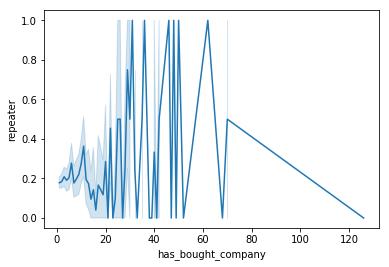

In [32]:
import seaborn as sns
ax = sns.lineplot(x = "has_bought_company",y="repeater",data = train_offer_)

Below are the actual found rates wrt has_bought_company


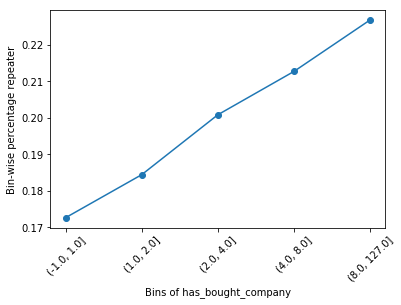

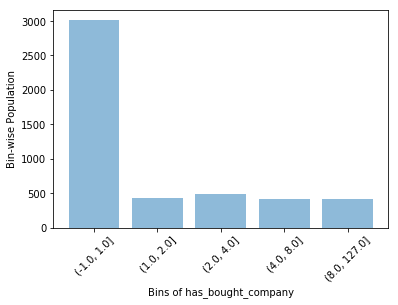

,has_bought_company,y_mean,y_sum,has_bought_company_mean
0,"(-1.0, 1.0]",0.172597,3007,0.237113
1,"(1.0, 2.0]",0.184397,423,2.000000
2,"(2.0, 4.0]",0.200828,483,3.445135
3,"(4.0, 8.0]",0.212714,409,6.210269
4,"(8.0, 127.0]",0.226829,410,16.765854


In [123]:
univariate_plotter(feature='has_bought_company', train_sub_col_target=train_offer_, target_col='repeater', bins=10)

Next, we classify the cases into different groups by creating bins of number of brands each customer buys. This way, we can visualize the return rates and number of customers(population) by groups.

Below are the actual found rates wrt has_bought_brand


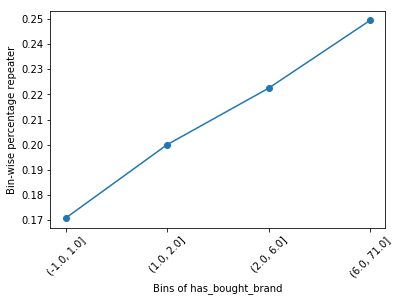

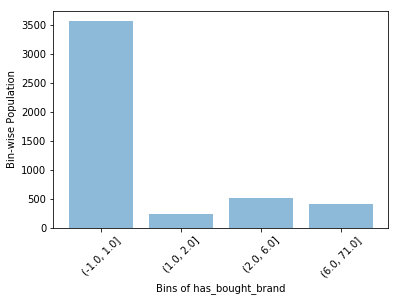

,has_bought_brand,y_mean,y_sum,has_bought_brand_mean
0,"(-1.0, 1.0]",0.170827,3565,0.111360
1,"(1.0, 2.0]",0.200000,245,2.000000
2,"(2.0, 6.0]",0.222437,517,4.189555
3,"(6.0, 71.0]",0.249383,405,14.333333


In [122]:
univariate_plotter(feature='has_bought_brand', train_sub_col_target=train_offer_, target_col='repeater', bins=10)

Below are the actual found rates wrt has_bought_category


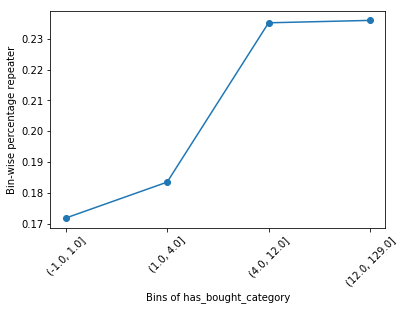

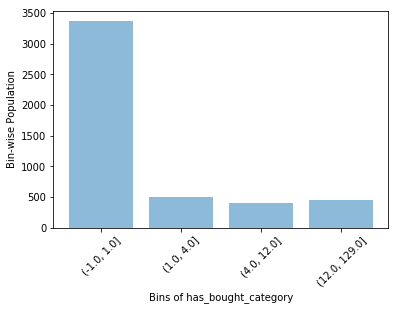

,has_bought_category,y_mean,y_sum,has_bought_category_mean
0,"(-1.0, 1.0]",0.171810,3370,0.148071
1,"(1.0, 4.0]",0.183468,496,2.812500
2,"(4.0, 12.0]",0.235149,404,7.646040
3,"(12.0, 129.0]",0.235931,462,25.614719


In [124]:
univariate_plotter(feature='has_bought_category', train_sub_col_target=train_offer_, target_col='repeater', bins=10)

Next, we will conduct the correlation analysis among the features so that we can have a more intuitive understanding of the covariation and relationships of these features. In the Positive correlations are displayed in red and negative correlations in green color. Color intensity is proportional to the correlation coefficients.

In [84]:
cols=[
    "has_bought_company", "quantity",
      "has_bought_company_amount", "has_bought_company_q",
      "has_bought_category", "has_bought_category_amount", "has_bought_category_q",
      "has_bought_brand", "has_bought_brand_amount", "has_bought_brand_q",
 #   "Delta",
   "has_bought_all", "has_bought_company_30","has_bought_company_60","has_bought_company_90",
    "has_bought_brand_30","has_bought_brand_60","has_bought_brand_90",
    "has_bought_category_30","has_bought_category_60","has_bought_category_90",
    "has_bought_all_amount","has_bought_all_q",
    "offervalue",'total_times',
     'total_amount','total_q'] 

X_train, X_test, y_train, y_test = train_test_split(train_offer_[cols], 
                                                     train_offer_['repeater'], test_size=0.2, random_state=0)


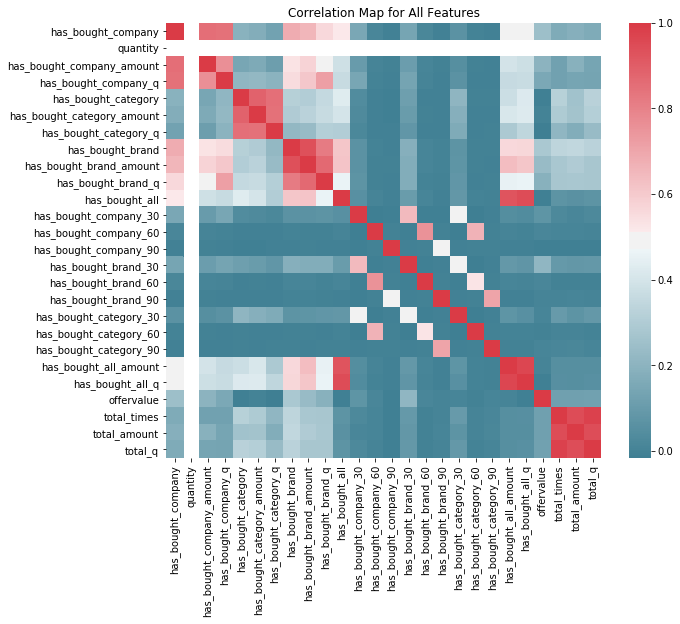

In [119]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train.corr()
ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
ax.set_title('Correlation Map for All Features')
plt.show()

## Model Building
### 1. Logistic Regression

In [87]:
cols=[
    "has_bought_company", "quantity",
      "has_bought_company_amount", "has_bought_company_q",
      "has_bought_category", "has_bought_category_amount", "has_bought_category_q",
      "has_bought_brand", "has_bought_brand_amount", "has_bought_brand_q",
 #   "Delta",
   "has_bought_all", "has_bought_company_30","has_bought_company_60","has_bought_company_90",
    "has_bought_brand_30","has_bought_brand_60","has_bought_brand_90",
    "has_bought_category_30","has_bought_category_60","has_bought_category_90",
    "has_bought_all_amount","has_bought_all_q",
    "offervalue",'total_times',
     'total_amount','total_q'] 

X_train, X_test, y_train, y_test = train_test_split(train_offer_[cols], 
                                                     train_offer_['repeater'], test_size=0.2, random_state=0)

In [93]:
from sklearn.grid_search import GridSearchCV
from sklearn import grid_search
from sklearn.metrics import roc_auc_score
logreg = LogisticRegression(penalty='l1', solver='liblinear',C=100)
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:,1]
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
performance = roc_auc_score(y_test, y_pred)
print ('Logistic Regression: Area under the ROC curve = {}'.format(performance))

Accuracy of logistic regression classifier on training set: 0.82
Accuracy of logistic regression classifier on test set: 0.81
Logistic Regression: Area under the ROC curve = 0.5851971622314662


In [95]:
logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True False  True  True False False False  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True False
 False False]
[1 1 6 1 1 3 4 2 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 7 9 8]


In [59]:
from sklearn.feature_selection import f_classif
f_classif(X_train,y_train)

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(array([  4.04023787,          nan,   3.15344253,   1.46101095,
         10.96661338,  19.69761165,  10.70177851,  10.17324837,
         13.48587595,   4.66126931,  29.99636472,   0.20566592,
          0.07314886,   0.44593301,   0.86035822,   0.12306138,
          0.44593301,   2.99475209,   0.17648542,   0.22289444,
         31.48799709,  29.73017011,   0.50925039,  10.05525484,
         13.72673972,  15.70253885]),
 array([  4.44984238e-02,              nan,   7.58473297e-02,
          2.26844880e-01,   9.36389104e-04,   9.33001020e-06,
          1.07992686e-03,   1.43656805e-03,   2.43688604e-04,
          3.09130577e-02,   4.61025881e-08,   6.50211842e-01,
          7.86820782e-01,   5.04313392e-01,   3.53697639e-01,
          7.25757137e-01,   5.04313392e-01,   8.36162448e-02,
          6.74435031e-01,   6.36870525e-01,   2.15067051e-08,
          5.28304667e-08,   4.75507557e-01,   1.53128306e-03,
          2.14444721e-04,   7.54918789e-05]))

In [60]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train.astype(float),X_train.astype(float))
result=logit_model.fit()
print(result.summary())

         Current function value: 0.466863
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               repeater   No. Observations:                 3785
Model:                          Logit   Df Residuals:                     3759
Method:                           MLE   Df Model:                           25
Date:                Fri, 29 Jun 2018   Pseudo R-squ.:                 0.01684
Time:                        09:41:08   Log-Likelihood:                -1767.1
converged:                      False   LL-Null:                       -1797.3
                                        LLR p-value:                 8.787e-05
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
has_bought_company            -0.0157      0.033     -0.477      0.633        -0.080     0.049
quantity         

C:\Users\kathl\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### 2.Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = "gini", splitter = 'random', max_leaf_nodes = 5, min_samples_leaf = 5, max_depth= 5)
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict_proba(X_test)[:,1]
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print(clf.feature_importances_)
performance = roc_auc_score(y_test, y_pred_tree)
print ('DecisionTree: Area under the ROC curve = {}'.format(performance))

Accuracy of Decision Tree classifier on training set: 0.82
Accuracy of Decision Tree classifier on test set: 0.81
[0.         0.         0.         0.         0.         0.
 0.08583677 0.         0.         0.         0.119805   0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.69656351 0.         0.
 0.         0.09779472]
DecisionTree: Area under the ROC curve = 0.593498917317226


In [80]:
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 
 # Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 18}


C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kathl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


### 3. Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(criterion = "gini", max_leaf_nodes= 18,min_samples_leaf = 1, max_depth= 10,n_estimators=18)
# min_samples_leaf = 10, 15 
# Train the model on training data
rf.fit(X_train, y_train);

predictions = rf.predict_proba(X_test)[:,1]
print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

performance = roc_auc_score(y_test, predictions)
print ('Random Forest: Area under the ROC curve = {}'.format(performance))

Accuracy of Random Forest classifier on training set: 0.83
Accuracy of Random Forest classifier on test set: 0.81
Random Forest: Area under the ROC curve = 0.6122001253632686


In [100]:
print(rf.feature_importances_)
print(cols)

[ 0.04201335  0.          0.05516629  0.04264195  0.0412595   0.03608702
  0.03503255  0.02968182  0.02832364  0.0273683   0.08371838  0.06840645
  0.11483007  0.07889876  0.0210911   0.07277819  0.10214323  0.1205594 ]
['has_bought_company', 'quantity', 'has_bought_company_amount', 'has_bought_company_q', 'has_bought_category', 'has_bought_category_amount', 'has_bought_category_q', 'has_bought_brand', 'has_bought_brand_amount', 'has_bought_brand_q', 'Delta', 'has_bought_all', 'has_bought_all_amount', 'has_bought_all_q', 'offervalue', 'total_times', 'total_amount', 'total_q']


### 4. XGboost

In [100]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)

params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':3,
    'gamma':0,
    'lambda':3,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':3,
    'eta': 0.007,
    'seed':0,
    'nthread':8,
     'silent':0}

watchlist = [(dtrain,'train')]

In [103]:
bst=xgb.train(params,dtrain,num_boost_round=500,evals=watchlist)
ypred=bst.predict(dtest)
y_pred = (ypred >= 0.5)*1

[22:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.578392
[22:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.587779
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.591104
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.592512
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-auc:0.592114
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-auc:0.592253
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-auc:0.596837
[22:55:14] src/tree/updater_prune.cc:74: tree pruning e

[60]	train-auc:0.617485
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[61]	train-auc:0.617497
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[62]	train-auc:0.61726
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[63]	train-auc:0.61726
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[64]	train-auc:0.617273
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[65]	train-auc:0.617431
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[66]	train-auc:0.617561
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[67]	train-auc:0.617757
[22:55:14] src/tree/update

[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[121]	train-auc:0.625729
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[122]	train-auc:0.625973
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[123]	train-auc:0.62598
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[124]	train-auc:0.626265
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[125]	train-auc:0.626298
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[126]	train-auc:0.626387
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[127]	train-auc:0.626666
[22:55:14] src/tree/updater_prune.cc:74: t

[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[181]	train-auc:0.634318
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[182]	train-auc:0.634322
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[183]	train-auc:0.634734
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[184]	train-auc:0.634768
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[185]	train-auc:0.635575
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[186]	train-auc:0.635864
[22:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[187]	train-auc:0.635847
[22:55:14] src/tree/updater_prune.cc:74: 

[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[241]	train-auc:0.642901
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[242]	train-auc:0.643039
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[243]	train-auc:0.643248
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[244]	train-auc:0.643422
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[245]	train-auc:0.643581
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[246]	train-auc:0.643589
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[247]	train-auc:0.643542
[22:55:15] src/tree/updater_prune.cc:74: 

[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[301]	train-auc:0.651175
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[302]	train-auc:0.651615
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[303]	train-auc:0.65183
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[304]	train-auc:0.652092
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[305]	train-auc:0.652264
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[306]	train-auc:0.652569
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[307]	train-auc:0.652604
[22:55:15] src/tree/updater_prune.cc:74: t

[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[361]	train-auc:0.663759
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[362]	train-auc:0.663966
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[363]	train-auc:0.664084
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[364]	train-auc:0.664182
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[365]	train-auc:0.664341
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[366]	train-auc:0.664735
[22:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[367]	train-auc:0.664945
[22:55:15] src/tree/updater_prune.cc:74: 

[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[421]	train-auc:0.674532
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[422]	train-auc:0.67487
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[423]	train-auc:0.674871
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[424]	train-auc:0.675126
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[425]	train-auc:0.675235
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[426]	train-auc:0.675443
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[427]	train-auc:0.675559
[22:55:16] src/tree/updater_prune.cc:74: t

[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[481]	train-auc:0.682717
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[482]	train-auc:0.682825
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[483]	train-auc:0.682921
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[484]	train-auc:0.683022
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[485]	train-auc:0.683059
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[486]	train-auc:0.683023
[22:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[487]	train-auc:0.683163
[22:55:16] src/tree/updater_prune.cc:74: 

In [115]:
from sklearn import metrics
print('XGBoost: Area under the ROC curve = %.4f' % metrics.roc_auc_score(y_test,ypred))

XGBoost: Area under the ROC curve = 0.6288


In [110]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
# feature importance
print(model.feature_importances_)
importances = list(model.feature_importances_)
feature_list = list(cols)
feature_importances = [(feature,round(importance,2)) for feature,importance in zip(feature_list,importances)]
feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse = True)
[print('Variable: {:20}Importance: {}'.format(*pair))for pair in feature_importances];

[0.0374415  0.         0.10140406 0.05928237 0.03432137 0.07176287
 0.02964118 0.01716069 0.03120125 0.01560062 0.00468019 0.00468019
 0.         0.         0.00156006 0.         0.         0.00624025
 0.         0.         0.05460218 0.00156006 0.03276131 0.12948518
 0.18876755 0.17784712]
Variable: total_amount        Importance: 0.1899999976158142
Variable: total_q             Importance: 0.18000000715255737
Variable: total_times         Importance: 0.12999999523162842
Variable: has_bought_company_amountImportance: 0.10000000149011612
Variable: has_bought_category_amountImportance: 0.07000000029802322
Variable: has_bought_company_qImportance: 0.05999999865889549
Variable: has_bought_all_amountImportance: 0.05000000074505806
Variable: has_bought_company  Importance: 0.03999999910593033
Variable: has_bought_category Importance: 0.029999999329447746
Variable: has_bought_category_qImportance: 0.029999999329447746
Variable: has_bought_brand_amountImportance: 0.029999999329447746
Variable